### Goal
Predict if a passenger survived the sinking of the Titanic or not. 

### Python

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Read and describe the training data

In [2]:
df = pd.read_csv('train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
round(df.describe(), 2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


### Probability of survival for class and sex

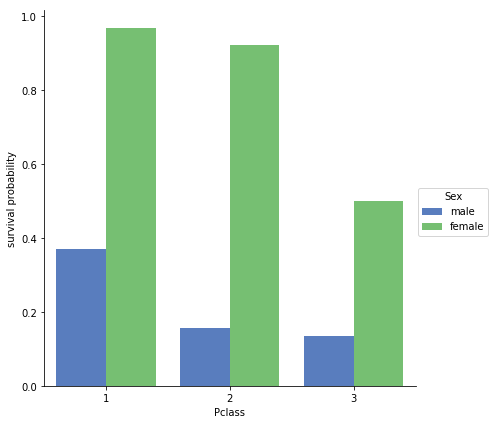

In [4]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=df, size=6, kind='bar', palette='muted', ci=None)

g.set_ylabels('survival probability')

#### Survival percentage per group

In [5]:
max_child_age = 12
total = float(len(df))

survived = df[df['Survived'] == True]
female = df[df['Sex'] == 'female']
male = df[df['Sex'] == 'male']
male_child = df[(df['Sex'] == 'male') & (df['Age'] <= max_child_age)]
male_adult = df[(df['Sex'] == 'male') & (df['Age'] > max_child_age)]
select_woman_or_child = (df['Sex'] == 'female') | (df['Age'] <= max_child_age)
woman_or_child = df[select_woman_or_child]
not_woman_or_child = df[~select_woman_or_child]

print('From %d passengers %d%% (%d) survived.' % (total, df.Survived.mean() * 100, len(survived)))
print('Female: %d%% (%d)' % (female.Survived.mean() * 100, len(female)))
print('Male: %d%% (%d)' % (male.Survived.mean() * 100, len(male)))
print('Male and child: %d%% (%d)' % (male_child.Survived.mean() * 100, len(male_child)))
print('Female or child: %d%% (%d)' % (woman_or_child.Survived.mean() * 100, len(woman_or_child)))
print('Not (Female or child): %d%% (%d)' % (not_woman_or_child.Survived.mean() * 100, len(not_woman_or_child)))

From 891 passengers 38% (342) survived.
Female: 74% (314)
Male: 18% (577)
Male and child: 56% (37)
Female or child: 72% (351)
Not (Female or child): 16% (540)


#### Prediction and accuracy

In [6]:
no_one_survived = total - len(survived)
woman_survived = len(female[female.Survived == True]) + len(male[male.Survived == False])
woman_or_child_survived = len(woman_or_child[woman_or_child.Survived == True]) + \
                          len(not_woman_or_child[not_woman_or_child.Survived == False])

print('No one will survive: %.2f' % (no_one_survived * 100 / total))
print('Woman will survive: %.2f' % (woman_survived * 100 / total))
print('Woman and children will survive: %.2f' % (woman_or_child_survived * 100 / total))

No one will survive: 61.62
Woman will survive: 78.68
Woman and children will survive: 79.24


### Baseline prediction with 79.24% accuracy:  All woman and children will survive!

### Prepare the data
#### Add test data to main dataset

In [7]:
test_df = pd.read_csv('test.csv')
df = pd.concat([df, test_df], sort=False)

#### One-hot encode 'Embarked' and dummy encode 'Sex' to 'Is_male'

In [8]:
embarked = pd.get_dummies(df.Embarked, prefix='Embarked', dtype=bool)
df = pd.concat([df, embarked], axis=1)
df = df.drop(columns=['Embarked'])

df['Sex'] = df['Sex'] == 'male'
df.rename(columns={'Sex': 'Is_male'}, inplace=True)

df.head(3)

,PassengerId,Survived,Pclass,Name,Is_male,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",True,22.0,1,0,A/5 21171,7.2500,NaN,False,False,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",False,38.0,1,0,PC 17599,71.2833,C85,True,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",False,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,False,True


### Name formatting
**Count the spaces in the name. Perhaps it's easier to survive with longer name.**

In [9]:
df['Name_spaces'] = df.Name.str.count(' ')

#### English honorifics

In [10]:
print('Total passengers:', len(df))
print('Mr.', len(df[df.Name.str.contains('Mr\.')]))
print('Miss.', len(df[df.Name.str.contains('Miss\.')]))
print('Mrs.', len(df[df.Name.str.contains('Mrs\.')]))
print('Master.', len(df[df.Name.str.contains('Master\.')]))
print('Dr', len(df[df.Name.str.contains('Dr')]))
print('Sir', len(df[df.Name.str.contains('Sir')]))
print('Ms', len(df[df.Name.str.contains('Ms')]))
print('Lady', len(df[df.Name.str.contains('Lady')]))
print('Lord', len(df[df.Name.str.contains('Lord')]))
print('General', len(df[df.Name.str.contains('General')]))
print('Captain', len(df[df.Name.str.contains('Captain')]))

Total passengers: 1309
Mr. 757
Miss. 260
Mrs. 197
Master. 61
Dr 17
Sir 3
Ms 2
Lady 1
Lord 0
General 0
Captain 0


In [11]:
df['Mr'] = df.Name.str.contains('Mr\.')
df['Miss'] = df.Name.str.contains('Miss\.')
df['Mrs'] = df.Name.str.contains('Mrs\.')
df['Master'] = df.Name.str.contains('Master\.')

df[['Name', 'Name_spaces', 'Mr', 'Miss', 'Mrs', 'Master']].head(8)

,Name,Name_spaces,Mr,Miss,Mrs,Master
0,"Braund, Mr. Owen Harris",3,True,False,False,False
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",6,False,False,True,False
2,"Heikkinen, Miss. Laina",2,False,True,False,False
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",6,False,False,True,False
4,"Allen, Mr. William Henry",3,True,False,False,False
5,"Moran, Mr. James",2,True,False,False,False
6,"McCarthy, Mr. Timothy J",3,True,False,False,False
7,"Palsson, Master. Gosta Leonard",3,False,False,False,True


### Age
**Age is fractional if less than 1  
If the age is estimated, is it in the form of xx.5  
Missing age is 'NaN'**

In [12]:
# Display old values
print('Example on missing, real age and estimated age: \n')
print(df[['Age']][55:58])

# Make new column, True if age is NaN
df['Age_is_null'] = df.Age.isnull()

# Replace NaN values with mean Age
mean_age = int(round(df.Age.mean()))
df['Age'] = df['Age'].fillna(mean_age)

# Make new column, True if age is estimated
estimated_selection = df['Age'].astype(int) != df['Age']
fractional_selection = df['Age'] < 1
df['Age_is_estimated'] = estimated_selection & ~fractional_selection

# Display new values
print('\nFormatted age values:')
df[['Age', 'Age_is_null', 'Age_is_estimated']][55:58]

Example on missing, real age and estimated age: 

     Age
55   NaN
56  21.0
57  28.5

Formatted age values:


,Age,Age_is_null,Age_is_estimated
55,30.0,True,False
56,21.0,False,False
57,28.5,False,True


#### One-hot encode 'Cabin' deck info

In [13]:
df['Deck_a'] = df.Cabin.str.contains('A', na=False)
df['Deck_b'] = df.Cabin.str.contains('B', na=False)
df['Deck_c'] = df.Cabin.str.contains('C', na=False)
df['Deck_d'] = df.Cabin.str.contains('D', na=False)
df['Deck_e'] = df.Cabin.str.contains('E', na=False)
df['Deck_f'] = df.Cabin.str.contains('F', na=False)
df['Deck_g'] = df.Cabin.str.contains('G', na=False)

#### Log transform Fare
Make the skewed distribution as normal-like as possible. 

In [14]:
# Replace one NaN value with mean
df['Fare'] = df['Fare'].fillna(df.Fare.mean())

df['Fare_log'] = np.log((1 + df['Fare']))
df['Fare_log_round'] = round(df.Fare_log).astype(int)
round(df[['Fare', 'Fare_log', 'Fare_log_round']].describe(), 2)

,Fare,Fare_log,Fare_log_round
count,1309.00,1309.00,1309.00
mean,33.30,2.98,2.89
std,51.74,0.97,1.02
min,0.00,0.00,0.00
25%,7.90,2.19,2.00
50%,14.45,2.74,3.00
75%,31.28,3.47,3.00
max,512.33,6.24,6.00


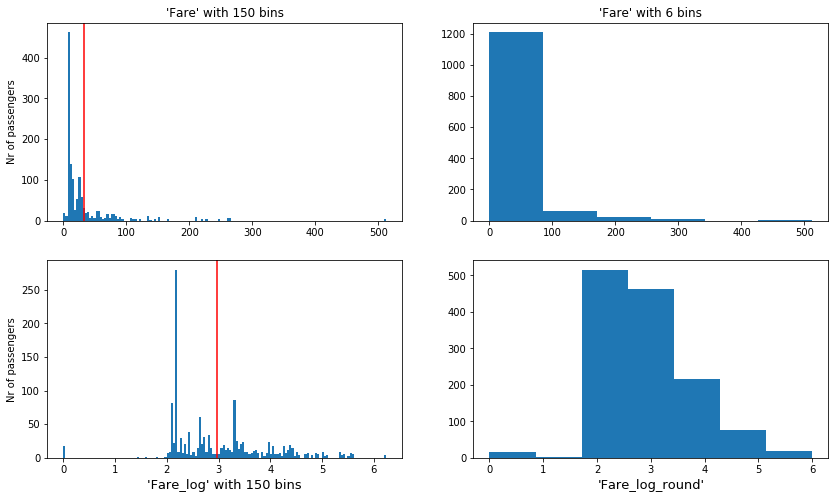

Red line is mean


In [15]:
plt.figure(1, figsize=(14, 8))

plt.subplot(221)
n, bins, patches = plt.hist(df.Fare, 150)
plt.axvline(df.Fare.mean(), color='r')
plt.title('\'Fare\' with 150 bins')
plt.ylabel('Nr of passengers')

plt.subplot(222)
n, bins, patches = plt.hist(df.Fare, 6)
plt.title('\'Fare\' with 6 bins')

plt.subplot(223)
n, bins, patches = plt.hist(df.Fare_log, 150)
plt.axvline(df.Fare_log.mean(), color='r')
plt.xlabel('\'Fare_log\' with 150 bins', size=13)
plt.ylabel('Nr of passengers')

plt.subplot(224)
n, bins, patches = plt.hist(df.Fare_log_round, len(df.Fare_log_round.unique()))
plt.xlabel('\'Fare_log_round\'', size=13)
plt.show()
print('Red line is mean')

### Split data into features, labels and submission

In [16]:
submission_selection = df.Survived.isnull()

# Select train values and convert to numpy array
y = np.array(df[~submission_selection].Survived)

# Remove unnecessary columns
X = df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

# Split submission data
X_submission = X[submission_selection]
X = X[~submission_selection]

pd.set_option('display.max_columns', None)
X.head(6)

,Pclass,Is_male,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Name_spaces,Mr,Miss,Mrs,Master,Age_is_null,Age_is_estimated,Deck_a,Deck_b,Deck_c,Deck_d,Deck_e,Deck_f,Deck_g,Fare_log,Fare_log_round
0,3,True,22.0,1,0,7.2500,False,False,True,3,True,False,False,False,False,False,False,False,False,False,False,False,False,2.110213,2
1,1,False,38.0,1,0,71.2833,True,False,False,6,False,False,True,False,False,False,False,False,True,False,False,False,False,4.280593,4
2,3,False,26.0,0,0,7.9250,False,False,True,2,False,True,False,False,False,False,False,False,False,False,False,False,False,2.188856,2
3,1,False,35.0,1,0,53.1000,False,False,True,6,False,False,True,False,False,False,False,False,True,False,False,False,False,3.990834,4
4,3,True,35.0,0,0,8.0500,False,False,True,3,True,False,False,False,False,False,False,False,False,False,False,False,False,2.202765,2
5,3,True,30.0,0,0,8.4583,False,True,False,2,True,False,False,False,True,False,False,False,False,False,False,False,False,2.246893,2


In [17]:
my_random_state = 10

X_columns = list(X.columns)
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_random_state)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)
print('X_submission shape', X_submission.shape)

X_train shape (668, 25)
y_train shape (668,)
X_test shape (223, 25)
y_test shape (223,)
X_submission shape (418, 25)


### Train Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1001, random_state=my_random_state)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1001, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

### Predict

In [19]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

print('Accuracy: %.2f' % (100 - sum(errors) * 100 / len(errors)))

Accuracy: 83.41


### Feature importances

In [20]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_columns, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print out the feature and importance's 
feature_importances

[('Age', 0.15),
 ('Is_male', 0.12),
 ('Fare', 0.12),
 ('Fare_log', 0.12),
 ('Mr', 0.09),
 ('Pclass', 0.06),
 ('Name_spaces', 0.06),
 ('SibSp', 0.05),
 ('Parch', 0.03),
 ('Miss', 0.03),
 ('Mrs', 0.03),
 ('Fare_log_round', 0.03),
 ('Embarked_S', 0.02),
 ('Age_is_null', 0.02),
 ('Embarked_C', 0.01),
 ('Embarked_Q', 0.01),
 ('Master', 0.01),
 ('Deck_b', 0.01),
 ('Deck_c', 0.01),
 ('Deck_d', 0.01),
 ('Deck_e', 0.01),
 ('Age_is_estimated', 0.0),
 ('Deck_a', 0.0),
 ('Deck_f', 0.0),
 ('Deck_g', 0.0)]

### Visualizing a Single Decision Tree

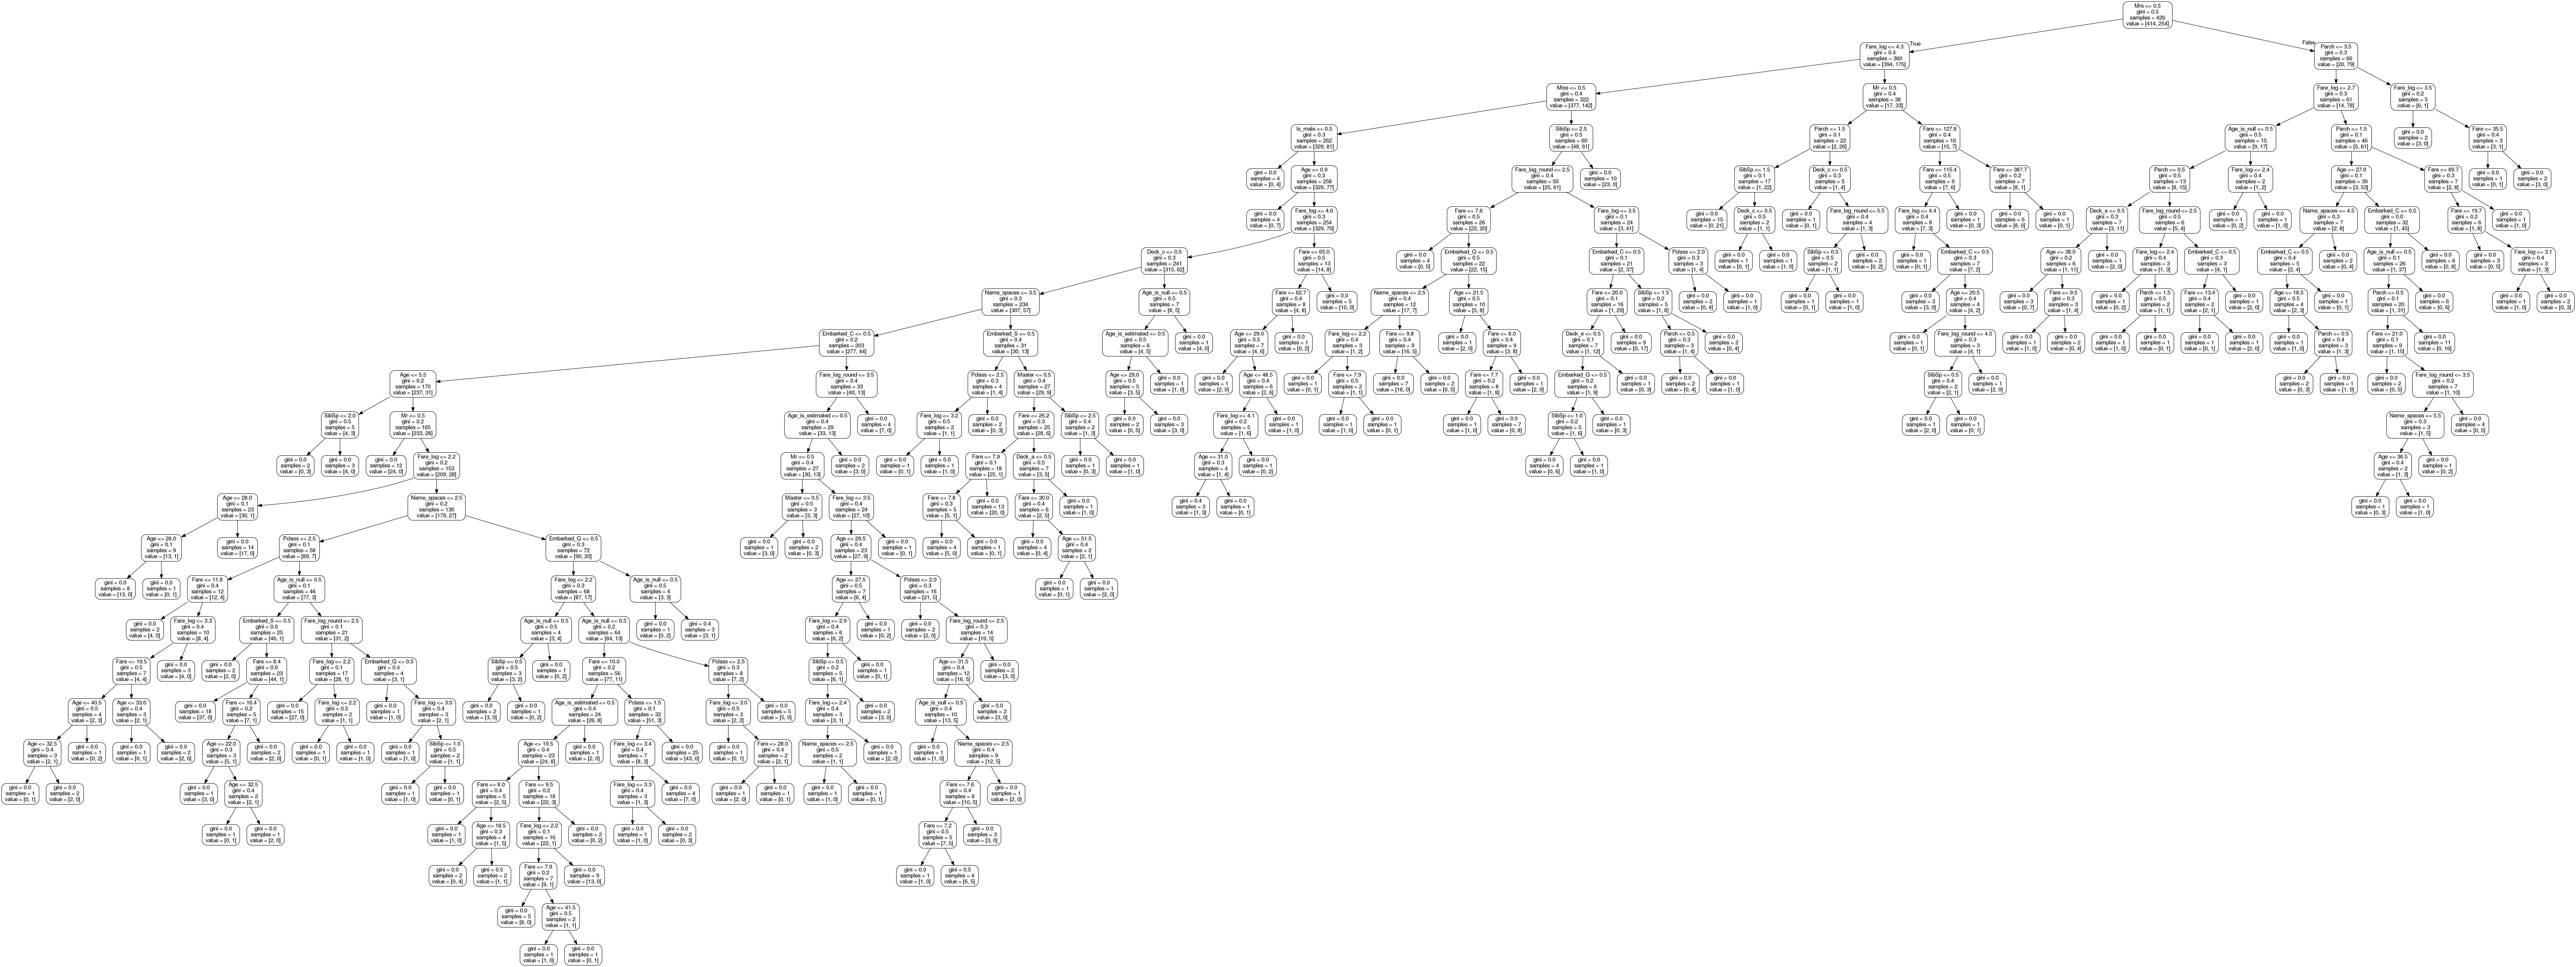

In [21]:
# To install missing packages, run in terminal:
# conda install graphviz pydot
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[0]

# Export the image to a dot file
export_graphviz(tree, out_file='tree.dot', feature_names=X_columns, rounded=True, precision=1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

# Display the image
Image("tree.png")

### Hyperparameter Tuning

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

#### Use the random grid to search for best hyperparameters

In [23]:
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 40 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter=40, 
                               cv=3, 
                               verbose=1, 
                               random_state=my_random_state, 
                               n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   49.6s finished


{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

In [24]:
def evaluate(model, X, y):
    predictions = model.predict(X)
    errors = abs(predictions - y)
    accu = (100 - sum(errors) * 100 / len(errors))
    print('Accuracy: %.2f' % accu)
    return accu

Base model

In [25]:
base_model = RandomForestClassifier(n_estimators=1001, random_state=my_random_state)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Accuracy: 83.41


RandomizedSearchCV model

In [26]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Accuracy: 84.75


Grid Search with Cross Validation

In [27]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 95, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 200]
}

# Create a based model
rf = RandomForestClassifier(random_state=my_random_state)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3, n_jobs=-1, 
                           verbose=1)

In [28]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   11.7s finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 200}

#### GridSearchCV model

In [29]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Accuracy: 85.20


#### Summary of hyperparameter tuning performance

In [30]:
print('Base model accuray: %.2f' % base_accuracy)
print('Randomized accuray: %.2f' % random_accuracy)
print('Grid Search accuray: %.2f' % grid_accuracy)

Base model accuray: 83.41
Randomized accuray: 84.75
Grid Search accuray: 85.20


### Submission
**Baseline**

In [31]:
path = 'submissions/woman_or_child_submission.csv'

test_df = pd.read_csv('test.csv')
select_woman_or_child = (test_df['Sex'] == 'female') | (test_df['Age'] <= max_child_age)
test_df['Survived'] = select_woman_or_child.astype(int)

test_df[['PassengerId', 'Survived']].to_csv(path, index=False)

**Base model**

In [32]:
path = 'submissions/base_model_submission.csv'

submission_predictions = base_model.predict(X_submission)
submission_df = df[submission_selection][['PassengerId']]
submission_df['Survived'] = submission_predictions.astype(int)

submission_df.to_csv(path, index=False)

**Grid Search Model**

In [33]:
path = 'submissions/best_grid_submission.csv'

best_grid_predictions = best_grid.predict(X_submission)
best_grid_df = df[submission_selection][['PassengerId']]
best_grid_df['Survived'] = best_grid_predictions.astype(int)

best_grid_df.to_csv(path, index=False)

### Summary of submission scores from kaggle:
No one will survive: 0.62679 (61.62)  
Woman will survive: 0.76555 (78.68)  
**Woman and children will survive: 0.77033** (79.24)  
Base model: 0.75598 (83.41)  
**Grid Search model: 0.77511** (85.20)**  
  
kaggel ranking: 6210 out of 11260